## 📥 Step 1 – Upload and Load Dataset

We begin by uploading the Online Retail dataset (Excel format) and loading it into a pandas DataFrame using `pd.read_excel()`.  
This dataset contains all transactions made by customers between 01/12/2010 and 09/12/2011 for a UK-based online retailer.


In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Load dataset
df = pd.read_excel("Online Retail.xlsx")

# Preview
df.head()


Saving Online Retail.xlsx to Online Retail.xlsx


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 🧹 Step 2 – Data Cleaning

To ensure accurate RFM analysis, we clean the dataset by:

- Removing rows without a CustomerID  
- Filtering out canceled transactions (invoices starting with “C”)  
- Removing transactions with Quantity ≤ 0  
- Converting InvoiceDate to datetime format  
- Creating a new column `TotalPrice = Quantity × UnitPrice`

This ensures we’re working only with valid, successful sales linked to identifiable customers.


In [3]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


## 🗓️ Step 3 – Define the Reference Date

RFM Recency is calculated as the number of days since the customer’s last purchase.  
To do that, we define a consistent “today” or reference date.  
We set it as one day after the last invoice date in the dataset



In [4]:
import datetime as dt

ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


## 📊 Step 4 – Calculate RFM Metrics

We now group the data by `CustomerID` and calculate the three core RFM values:

- 📅 Recency: Days since the most recent purchase  
- 🔁 Frequency: Number of unique purchase invoices  
- 💰 Monetary: Total spending (sum of TotalPrice)

This creates a clean customer-level summary for segmentation.

In [5]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


## 🔢 Step 5 – Score RFM Metrics

To rank and compare customers, we assign a score of 1 to 5 for each RFM metric:

- Recency: Lower recency (recent purchase) gets higher score  
- Frequency: More purchases = higher score  
- Monetary: Higher spenders get higher score

We combine these scores into an RFM segment (e.g. "431") and total score.


In [6]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine scores
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)


## 🧱 Step 6 – Segment Customers

Based on the total RFM score (sum of R + F + M), we divide customers into 4 segments:

- 💎 Champions  
- 💡 Loyal  
- ⚠️ At Risk  
- 💤 Lost

These groups help businesses target customers based on behavior.


In [7]:
rfm['Segment'] = pd.cut(
    rfm['RFM_Score'],
    bins=[2, 6, 9, 12, 15],
    labels=['Lost', 'At Risk', 'Loyal', 'Champions']
)


## 📊 Step 7 – Visualize Segments

We use the following visualizations to better understand the RFM segmentation:

- 📊 A bar chart showing the count of customers in each segment  
- 🔥 A heatmap showing the average Monetary value across Recency and Frequency score combinations


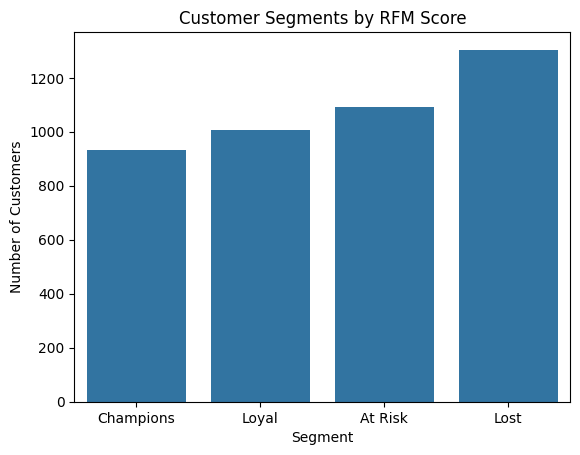

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Segment', data=rfm, order=['Champions', 'Loyal', 'At Risk', 'Lost'])
plt.title('Customer Segments by RFM Score')
plt.ylabel('Number of Customers')
plt.show()


/tmp/ipython-input-2498492349.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_table = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')


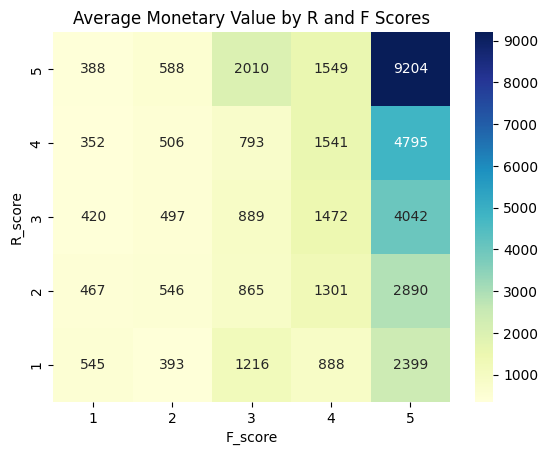

In [9]:
rfm_table = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')
sns.heatmap(rfm_table, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Average Monetary Value by R and F Scores')
plt.show()
